## 1. Data Preparation

In [2]:
# load packages
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(Matrix))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(iTALK))
suppressPackageStartupMessages(library(CellChat))
suppressPackageStartupMessages(library(SingleCellSignalR))
suppressPackageStartupMessages(library(CCInx))
suppressPackageStartupMessages(library(scMLnet))

# load tool functions
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CellChat.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_iTalk.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_SingleCellSignalR.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_scMLnet.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CCInx.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CellChat_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/iTalk_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/SingleCellSignalR_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CCInx_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/scMLnet_SSP_calculation.R")

In [11]:
# load single-cell sample data
GSE122960 <- readRDS("https://zenodo.org/record/6497091/files/GSE122960.rds?download=1")
GSE128033 <- readRDS("https://zenodo.org/record/6497091/files/GSE128033.rds?download=1")
GSE135893 <- readRDS("https://zenodo.org/record/6497091/files/GSE135893.rds?download=1")
GSE136831 <- readRDS("https://zenodo.org/record/6497091/files/GSE136831.rds?download=1")

All sample data has been processed, R scripts of processing can be found here: 
https://github.com/mora-lab/cell-cell-interactions/tree/main/benchmark-workflow/R

In [15]:
# cell types of the samples
unique(GSE122960$cell.type)

[1] "Macrophage"  "Fibroblast"  "AT2"         "Monocyte"    "Tcell"      
[6] "AT1"         "Endothelial" "Mast"

In [ ]:
# Subsample all data by patients as single samples
sampledata <- unique(GSE122960$orig.ident)
for(x in sampledata){
  sub <- subset(GSE122960, orig.ident == x)
  saveRDS(sub,paste("Dataset/GSE122960/", x, ".rds", sep = ""))
}

sampledata <- unique(GSE128033$orig.ident)
for(x in sampledata){
  sub <- subset(GSE128033, orig.ident == x)
  saveRDS(sub,paste("Dataset/GSE128033/", x, ".rds", sep = ""))
}

sampledata <- unique(GSE135893$Sample_Name)
for(x in sampledata){
  sub <- subset(GSE135893, Sample_Name == x)
  saveRDS(sub,paste("Dataset/GSE135893/", x, ".rds", sep = ""))
}

sampledata <- unique(GSE136831$orig.ident)
for(x in sampledata){
  sub <- subset(GSE136831, orig.ident == x)
  saveRDS(sub,paste("Dataset/GSE136831/", x, ".rds", sep = ""))
}

In [20]:
# all single samples
list.files("Dataset/GSE122960/")
list.files("Dataset/GSE128033/")
list.files("Dataset/GSE135893/")
list.files("Dataset/GSE136831/")

[1] "IPF_01.rds" "IPF_02.rds" "IPF_03.rds" "IPF_04.rds"

[1] "SC153IPFLOW.rds" "SC154IPFUP.rds"  "SC87IPFLOW.rds"  "SC88IPFUP.rds"  
[5] "SC89IPFLOW.rds"  "SC93IPFLOW.rds"  "SC94IPFUP.rds"   "SC95IPFLOW.rds"

[1] "TILD001.rds" "TILD006.rds" "TILD010.rds" "TILD015.rds" "TILD028.rds"
 [6] "VUILD53.rds" "VUILD59.rds" "VUILD60.rds" "VUILD61.rds" "VUILD63.rds"
[11] "VUILD64.rds" "VUILD65.rds"

[1] "010I.rds" "021I.rds" "022I.rds" "025I.rds" "034I.rds" "040I.rds"
 [7] "041I.rds" "051I.rds" "053I.rds" "063I.rds" "123I.rds" "135I.rds"
[13] "138I.rds" "145I.rds" "157I.rds" "158I.rds" "166I.rds" "174I.rds"
[19] "177I.rds" "179I.rds" "209I.rds" "210I.rds" "212I.rds" "214I.rds"
[25] "221I.rds" "222I.rds" "225I.rds" "228I.rds" "29I.rds"  "47I.rds" 
[31] "49I.rds"  "59I.rds"

In [3]:
allsample <- c(paste("Dataset/GSE122960/",list.files("Dataset/GSE122960/"),sep=""), 
               paste("Dataset/GSE128033/",list.files("Dataset/GSE128033/"),sep=""), 
               paste("Dataset/GSE135893/",list.files("Dataset/GSE135893/"),sep=""), 
               paste("Dataset/GSE136831/",list.files("Dataset/GSE136831/"),sep=""))
length(allsample) # amount of sample

[1] 56

In [ ]:
# remove original datasets to release memory
rm(GSE122960)
rm(GSE128033)
rm(GSE135893)
rm(GSE136831)
gc()

In [5]:
# load gold standard sample
gold <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/data/IPF gold standard.txt", header = TRUE, sep = "\t")
str(gold)
head(gold)

'data.frame':	208 obs. of  4 variables:
 $ source  : chr  "AT1" "AT1" "AT1" "AT1" ...
 $ target  : chr  "Monocyte" "Monocyte" "Monocyte" "Macrophage" ...
 $ ligand  : chr  "TGFB1" "TGFB1" "TGFB1" "TGFB1" ...
 $ receptor: chr  "TGFBR1" "TGFBR2" "TGFBR3" "TGFBR1" ...


,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,AT1,Monocyte,TGFB1,TGFBR1
2,AT1,Monocyte,TGFB1,TGFBR2
3,AT1,Monocyte,TGFB1,TGFBR3
4,AT1,Macrophage,TGFB1,TGFBR1
5,AT1,Macrophage,TGFB1,TGFBR2
6,AT1,Macrophage,TGFB1,TGFBR3


In [6]:
# select wanted genes for CellChat, iTalk, SingleCellSignalR, CCInx, CellPhoneDB and NATMI
genes <- unique(c(gold$ligand, gold$receptor))
# select wanted genes for scMLnet
rec <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/scMLnet_database/RecTF.txt", header = T, sep = "\t")
tf <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/scMLnet_database/TFTargetGene.txt", header = T, sep = "\t")
rec <- rec[rec$Receptor == genes,]
tf <- tf[tf$TF == rec$TF,]
genes2 <- unique(c(genes, rec$TF, tf$Targets))

Warning message in rec$Receptor == genes:
“longer object length is not a multiple of shorter object length”
Warning message in tf$TF == rec$TF:
“longer object length is not a multiple of shorter object length”


## 2. Cell-cell Interaction Prediction and SSP calculation (R tools) 

In [13]:
# CellChat
cclrpairs <- list()
ccssp <- data.frame()
ccroc <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  seu <- subset(seu, features = genes)
  cc <- run_CellChat(seu)
  cclrpairs[[sample]] <- cc
  result <- run_CellChat_SSP(cc,seu,gold)
  ccroc <- rbind(ccroc, result[["ROC"]])
  ccssp <- rbind(ccssp, result[["SSP"]])
}

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 16"
[1] "Time comsuming:"
   user  system elapsed 
  6.816   0.120   8.590 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  6.525   0.289   8.114 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 5"
[1] "Time comsuming:"
   user  system elapsed 
  7.241   0.074   7.599 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
  8.256   0.066   8.563 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 7"
[1] "Time comsuming:"
   user  system elapsed 
  6.991   0.051   7.064 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 7"
[1] "Time comsuming:"
   user  system elapsed 
  7.330   0.027   7.362 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 3"
[1] "Time comsuming:"
   user  system elapsed 
  7.659   0.020   7.695 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 5"
[1] "Time comsuming:"
   user  system elapsed 
  7.880   0.041   7.926 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 9"
[1] "Time comsuming:"
   user  system elapsed 
  7.968   0.248   8.486 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 10"
[1] "Time comsuming:"
   user  system elapsed 
  7.801   0.633  10.088 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  7.147   0.130   8.483 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 11"
[1] "Time comsuming:"
   user  system elapsed 
  7.118   0.226   8.079 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 21"
[1] "Time comsuming:"
   user  system elapsed 
  6.464   0.346   7.556 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 3"
[1] "Time comsuming:"
   user  system elapsed 
  6.400   0.012   6.654 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 8"
[1] "Time comsuming:"
   user  system elapsed 
  6.092   0.314   7.148 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 30"
[1] "Time comsuming:"
   user  system elapsed 
 10.114   0.098  12.732 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 5"
[1] "Time comsuming:"
   user  system elapsed 
  7.533   0.279   8.855 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 3"
[1] "Time comsuming:"
   user  system elapsed 
  5.657   0.026   5.727 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 4"
[1] "Time comsuming:"
   user  system elapsed 
 11.054   0.076  11.184 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 20"
[1] "Time comsuming:"
   user  system elapsed 
  7.219   0.003   7.305 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 4"
[1] "Time comsuming:"
   user  system elapsed 
  6.677   0.034   6.801 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 2"
[1] "Time comsuming:"
   user  system elapsed 
  4.769   0.005   4.925 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 10"
[1] "Time comsuming:"
   user  system elapsed 
  5.966   0.008   6.083 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 4"
[1] "Time comsuming:"
   user  system elapsed 
  5.202   0.000   5.262 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 20"
[1] "Time comsuming:"
   user  system elapsed 
  7.492   0.022   7.577 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 19"
[1] "Time comsuming:"
   user  system elapsed 
  7.264   0.015   7.373 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 11"
[1] "Time comsuming:"
   user  system elapsed 
  7.021   0.024   7.106 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  5.521   0.000   5.612 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 14"
[1] "Time comsuming:"
   user  system elapsed 
  7.115   0.004   7.227 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 16"
[1] "Time comsuming:"
   user  system elapsed 
  7.073   0.019   7.140 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 16"
[1] "Time comsuming:"
   user  system elapsed 
  7.333   0.000   7.338 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 19"
[1] "Time comsuming:"
   user  system elapsed 
  8.590   0.010   8.645 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  6.130   0.000   6.165 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 11"
[1] "Time comsuming:"
   user  system elapsed 
  6.176   0.033   6.247 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 5"
[1] "Time comsuming:"
   user  system elapsed 
  5.808   0.000   5.876 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  8.189   0.020   8.286 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 31"
[1] "Time comsuming:"
   user  system elapsed 
  7.438   0.005   7.467 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 12"
[1] "Time comsuming:"
   user  system elapsed 
  6.613   0.000   6.624 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 16"
[1] "Time comsuming:"
   user  system elapsed 
  7.954   0.035   8.018 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 7"
[1] "Time comsuming:"
   user  system elapsed 
  7.313   0.005   7.356 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 3"
[1] "Time comsuming:"
   user  system elapsed 
  7.181   0.004   7.220 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 20"
[1] "Time comsuming:"
   user  system elapsed 
  7.309   0.000   7.341 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  6.755   0.031   6.969 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 10"
[1] "Time comsuming:"
   user  system elapsed 
  7.042   0.050   7.104 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  5.922   0.033   5.960 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 10"
[1] "Time comsuming:"
   user  system elapsed 
  6.533   0.033   6.600 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 10"
[1] "Time comsuming:"
   user  system elapsed 
  6.052   0.035   6.093 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
  4.836   0.046   4.890 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  6.931   0.051   6.992 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 13"
[1] "Time comsuming:"
   user  system elapsed 
  9.237   0.030   9.281 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 13"
[1] "Time comsuming:"
   user  system elapsed 
 10.475   0.060  10.574 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 6"
[1] "Time comsuming:"
   user  system elapsed 
  6.045   0.052   6.117 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 14"
[1] "Time comsuming:"
   user  system elapsed 
  5.922   0.050   6.038 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 9"
[1] "Time comsuming:"
   user  system elapsed 
  5.919   0.022   5.949 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 2"
[1] "Time comsuming:"
   user  system elapsed 
  6.597   0.048   6.678 


Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



[1] "Total predicted L-R pairs: 25"
[1] "Time comsuming:"
   user  system elapsed 
  6.435   0.040   6.574 


In [14]:
head(cclrpairs[[1]])
head(ccssp)
head(ccroc)

,source,target,ligand,receptor,prob,pval
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Macrophage,AT1,TGFB1,TGFBR1,0.008518130,0.00
2,Macrophage,AT1,TGFB1,TGFBR2,0.008518130,0.00
21,Monocyte,AT1,TGFB1,TGFBR1,0.005556187,0.00
22,Monocyte,AT1,TGFB1,TGFBR2,0.005556187,0.00
3,Tcell,AT1,TGFB1,TGFBR1,0.002560141,0.02
31,Tcell,AT1,TGFB1,TGFBR2,0.002560141,0.02


,Accuracy,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>
1,0.8910714,0.038961039,0.9964895
2,0.8919643,0.008333333,0.9980000
3,0.8924107,0.008333333,0.9985000
4,0.8928571,0.000000000,0.9995002
5,0.8901786,0.008438819,0.9974962
6,0.8933036,0.017094017,0.9985000


,TPR,FPR
,<dbl>,<dbl>
1,0.038961039,0.0035105316
2,0.008333333,0.0020000000
3,0.008333333,0.0015000000
4,0.000000000,0.0004997501
5,0.008438819,0.0025037556
6,0.017094017,0.0015000000


In [27]:
# iTalk
itlrpairs <- list()
itssp <- data.frame()
itroc <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  seu <- subset(seu, features = genes)
  cc <- run_iTalk(seu,top = 196)
  itlrpairs[[sample]] <- cc
  result <- run_iTalk_SSP(cc,seu,gold)
  itroc <- rbind(itroc, result[["ROC"]])
  itssp <- rbind(itssp, result[["SSP"]])
}

[1] "Total predicted L-R pairs: 524"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.127   0.000   0.129 
[1] "Total predicted L-R pairs: 474"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.120   0.000   0.121 
[1] "Total predicted L-R pairs: 581"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.123   0.000   0.123 
[1] "Total predicted L-R pairs: 495"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.132   0.000   0.133 
[1] "Total predicted L-R pairs: 488"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.117   0.000   0.117 
[1] "Total predicted L-R pairs: 500"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.122   0.000   0.122 
[1] "Total predicted L-R pairs: 503"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.151   0.007   0.158 
[1] "Total pr

In [28]:
head(itlrpairs[[1]])
head(itssp)
head(itroc)

,source,target,ligand,receptor,source_mean_exprs,target_mean_exprs
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2,Fibroblast,Fibroblast,CTGF,LRP1,1.6200148,0.8041356
1,Fibroblast,Macrophage,CTGF,LRP1,1.6200148,0.7642434
20,Endothelial,Fibroblast,CTGF,LRP1,1.0156124,0.8041356
19,Endothelial,Macrophage,CTGF,LRP1,1.0156124,0.7642434
170,Monocyte,AT1,TGFB1,ITGB6,0.4554678,1.6820414
161,Macrophage,AT1,TGFB1,ITGB6,0.4263154,1.6820414


,Accuracy,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>
1,0.9035326,0.3235294,0.9522761
2,0.9028533,0.3103448,0.9512463
3,0.8885870,0.2574257,0.9468242
4,0.8977582,0.2572816,0.9476765
5,0.8889266,0.2378641,0.9458564
6,0.8987772,0.2912621,0.9500367


,TPR,FPR
,<dbl>,<dbl>
1,0.3235294,0.04772394
2,0.3103448,0.04875367
3,0.2574257,0.05317578
4,0.2572816,0.05232345
5,0.2378641,0.05414365
6,0.2912621,0.04996326


In [17]:
# SingleCellSignalR (threshold: LRscore > 0.5)
scsrlrpairs <- list()
scsrssp <- data.frame()
scsrroc <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  seu <- subset(seu, features = genes)
  cc <- run_SingleCellSignalR(seu)
  scsrlrpairs[[sample]] <- cc
  result <- run_SingleCellSignalR_SSP(cc,seu,gold)
  scsrroc <- rbind(scsrroc, result[["ROC"]])
  scsrssp <- rbind(scsrssp, result[["SSP"]])
}

[1] "Total predicted L-R pairs: 42"
[1] "Time comsuming:"
   user  system elapsed 
  0.551   0.012   0.576 
[1] "Total predicted L-R pairs: 14"
[1] "Time comsuming:"
   user  system elapsed 
  0.481   0.015   0.540 
[1] "Total predicted L-R pairs: 17"
[1] "Time comsuming:"
   user  system elapsed 
  0.816   0.008   0.827 
[1] "Total predicted L-R pairs: 33"
[1] "Time comsuming:"
   user  system elapsed 
  1.422   0.017   1.441 
[1] "Total predicted L-R pairs: 30"
[1] "Time comsuming:"
   user  system elapsed 
  0.739   0.008   0.748 
[1] "Total predicted L-R pairs: 23"
[1] "Time comsuming:"
   user  system elapsed 
  0.848   0.016   0.866 
[1] "Total predicted L-R pairs: 8"
[1] "Time comsuming:"
   user  system elapsed 
  1.043   0.010   1.053 
[1] "Total predicted L-R pairs: 24"
[1] "Time comsuming:"
   user  system elapsed 
  1.659   0.019   1.679 
[1] "Total predicted L-R pairs: 14"
[1] "Time comsuming:"
   user  system elapsed 
  0.991   0.002   0.994 
[1] "Total predicted L-R pair

In [18]:
head(scsrlrpairs[[1]])
head(scsrssp)
head(scsrroc)

,source,target,ligand,receptor,LRscore
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Macrophage,Tcell,CCL2,CCR4,0.556732057614387
2,Macrophage,Tcell,CCL3,CCR4,0.516319938302632
3,Fibroblast,Macrophage,CCL2,CCR1,0.815656113635841
4,Fibroblast,Macrophage,CCL2,CCR5,0.645739829044227
5,Fibroblast,Macrophage,CSF1,CSF1R,0.620898851228885
6,Fibroblast,AT2,CCL2,CCR1,0.506646176724377


,Accuracy,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>
1,0.9128289,0.07070707,0.9874664
2,0.9185855,0.03535354,0.9968666
3,0.9173520,0.03535354,0.9955237
4,0.9099507,0.03030303,0.9879141
5,0.9095395,0.02020202,0.9883617
6,0.9157072,0.04040404,0.9932856


,TPR,FPR
,<dbl>,<dbl>
1,0.07070707,0.012533572
2,0.03535354,0.003133393
3,0.03535354,0.004476276
4,0.03030303,0.012085944
5,0.02020202,0.011638317
6,0.04040404,0.006714414


In [7]:
# CCInx
ccilrpairs <- list()
ccissp <- data.frame()
cciroc <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  seu <- subset(seu, features = genes)
  cc <- run_CCInx(seu,top = 196)
  ccilrpairs[[sample]] <- cc
  result <- run_CCInx_SSP(cc,seu,gold)
  cciroc <- rbind(cciroc, result[["ROC"]])
  ccissp <- rbind(ccissp, result[["SSP"]])
}

Loading required package: scClustViz

-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1872"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.991   0.017   1.077 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1959"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.352   0.009   0.402 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 2286"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.340   0.006   0.408 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1205"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.883   0.011   0.969 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1667"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.340   0.012   0.413 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1844"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.872   0.023   0.956 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 2512"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.341   0.001   0.383 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 2277"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.902   0.024   0.933 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 2702"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.331   0.007   0.340 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 2005"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.299   0.011   0.310 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1502"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.309   0.000   0.319 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1752"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.303   0.007   0.314 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 828"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.261   0.002   0.322 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 855"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.225   0.012   0.273 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 688"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.272   0.018   0.363 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 2050"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.313   0.012   0.353 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1959"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.327   0.014   0.366 
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1268"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.299   0.003   0.314 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1242"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.283   0.000   0.304 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1501"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.297   0.000   0.309 
[1] "Total predicted L-R pairs: 0"
[1] "Total predicted L-R pairs: 0"
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1581"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.311   0.007   0.368 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1849"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.318   0.001   0.342 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1928"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.344   0.006   0.426 
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1341"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.282   0.015   0.309 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1484"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.293   0.007   0.312 
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1334"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.290   0.026   0.343 
[1] "Total predicted L-R pairs: 0"
[1] "Total predicted L-R pairs: 0"
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1238"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.314   0.001   0.343 
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1050"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.271   0.001   0.271 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1401"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.299   0.020   0.373 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1362"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.324   0.021   0.362 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1290"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.302   0.019   0.343 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1510"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.302   0.033   0.365 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1013"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.299   0.008   0.318 
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 812"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.243   0.002   0.288 
[1] "Total predicted L-R pairs: 0"
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 540"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.825   0.011   0.871 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 994"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.252   0.004   0.278 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1490"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.341   0.018   0.423 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 1655"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.349   0.002   0.365 


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 976"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.246   0.013   0.300 
[1] "Total predicted L-R pairs: 0"


-- Calculating cluster-wise gene statistics --

-- Calculating cluster-wise gene statistics --

Scaling node weights per cell type...

Building node metadata...

Building edge list...



[1] "Total predicted L-R pairs: 728"
[1] "Choose top L-R pairs: 196"
[1] "Time comsuming:"
   user  system elapsed 
  0.236   0.021   0.303 
[1] "Total predicted L-R pairs: 0"
[1] "Total predicted L-R pairs: 0"


In [8]:
head(ccilrpairs[[1]])
head(ccissp)
head(cciroc)

,source,target,ligand,receptor,edgeWeight
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Endothelial,Endothelial,CTGF,TGFBR2,0.999846834494715
2,Fibroblast,Endothelial,CTGF,TGFBR2,0.999846834494715
3,Endothelial,Endothelial,CTGF,TGFBR2,0.999846834494715
4,Fibroblast,Monocyte,CCL2,CCR1,0.992614903535032
5,Monocyte,Monocyte,TGFB1,ITGB1,0.978902776428303
6,Monocyte,AT2,TGFB1,ITGB6,0.978902776428303


,Accuracy,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>
1,0.9186921,0.1302083,0.9485095
2,0.9320023,0.2110553,0.9537954
3,0.9204282,0.1487179,0.9496836
4,0.9267940,0.1940299,0.9527251
5,0.9244792,0.1785714,0.9515206
6,0.9250579,0.1909548,0.9523666


,TPR,FPR
,<dbl>,<dbl>
1,0.1302083,0.05149051
2,0.2110553,0.04620462
3,0.1487179,0.05031636
4,0.1940299,0.04727492
5,0.1785714,0.04847937
6,0.1909548,0.04763340


In [25]:
# scMLnet
sclrpairs <- list()
scssp <- data.frame()
scroc <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  seu <- subset(seu, features = genes2)
  cc <- run_scMLnet(seu)
  sclrpairs[[sample]] <- cc
  result <- run_scMLnet_SSP(cc,seu,gold)
  scroc <- rbind(scroc, result[["ROC"]])
  scssp <- rbind(scssp, result[["SSP"]])
}

[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
182.340   0.612 184.061 
[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
187.252   0.332 187.724 
[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
182.890   0.355 183.359 
[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
157.776   0.313 158.180 
[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
171.682   0.306 172.151 
[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
172.095   0.425 172.586 
[1] "Total predicted L-R pairs: 2"
[1] "Time comsuming:"
   user  system elapsed 
175.950   0.451 176.448 
[1] "Total predicted L-R pairs: 0"
[1] "Time comsuming:"
   user  system elapsed 
178.885   0.419 179.397 
[1] "Total predicted L-R pairs: 4"
[1] "Time comsuming:"
   user  system elapsed 
180.908   0.385 181.342 
[1] "Total predicted L-R pairs: 0"
[1

In [23]:
# show one positive result only
head(sclrpairs[[7]])
scssp[7,]
scroc[7,]

,source,target,ligrec
,<chr>,<chr>,<chr>
1,Monocyte,Fibroblast,IL1A_IL1R1
2,Monocyte,Fibroblast,IL1B_IL1R1


,Accuracy,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>
7,0.9201858,0.005291005,0.9995411


,TPR,FPR
,<dbl>,<dbl>
7,0.005291005,0.0004589261


## 3. Save SSP and ROC Results (R tools)

In [29]:
ssp <- rbind(ccssp,itssp,scsrssp,ccissp,scssp)
tool <- rep(c("CellChat","iTalk","SingleCellSignalR","CCInx","scMLnet"),each=56)
ssp[,"Tool"] <- tool
head(ssp)

,Accuracy,Sensitivity,Specificity,Tool
,<dbl>,<dbl>,<dbl>,<chr>
1,0.8910714,0.038961039,0.9964895,CellChat
2,0.8919643,0.008333333,0.9980000,CellChat
3,0.8924107,0.008333333,0.9985000,CellChat
4,0.8928571,0.000000000,0.9995002,CellChat
5,0.8901786,0.008438819,0.9974962,CellChat
6,0.8933036,0.017094017,0.9985000,CellChat


In [30]:
roc <- rbind(ccroc,itroc,scsrroc,cciroc,scroc)
tool <- rep(c("CellChat","iTalk","SingleCellSignalR","CCInx","scMLnet"),each=56)
roc[,"Tool"] <- tool
head(roc)

,TPR,FPR,Tool
,<dbl>,<dbl>,<chr>
1,0.038961039,0.0035105316,CellChat
2,0.008333333,0.0020000000,CellChat
3,0.008333333,0.0015000000,CellChat
4,0.000000000,0.0004997501,CellChat
5,0.008438819,0.0025037556,CellChat
6,0.017094017,0.0015000000,CellChat


In [13]:
write.table(ssp,"Result/sspR.txt",row.names = F,sep="\t",quote = F)

In [17]:
write.table(roc,"Result/rocR.txt",row.names = F,sep="\t",quote = F)

## 4. Cell-cell Interaction Prediction (Python tools)

In [13]:
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CellPhoneDB process.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/NATMI process.R")
# inputdata preparation
for (sample in allsample){
  seu <- readRDS(sample)
  seu <- subset(seu, features = genes)
  CellPhoneDB_process(seu,strsplit(strsplit(sample,split="/")[[1]][3],split="\\.")[[1]][1])
  NATMI_process(seu,strsplit(strsplit(sample,split="/")[[1]][3],split="\\.")[[1]][1])
}

### Turn to Bash kernel:

In [1]:
# CellPhoneDB
ls Python/cpdb
ls Python/cpdb/010I/

010I  041I  138I  177I  221I  49I     SC153IPFLOW  SC94IPFUP   TILD028  VUILD64
021I  051I  145I  179I  222I  59I     SC154IPFUP   SC95IPFLOW  VUILD53  VUILD65
022I  053I  157I  209I  225I  IPF_01  SC87IPFLOW   TILD001     VUILD59
025I  063I  158I  210I  228I  IPF_02  SC88IPFUP    TILD006     VUILD60
034I  123I  166I  212I  29I   IPF_03  SC89IPFLOW   TILD010     VUILD61
040I  135I  174I  214I  47I   IPF_04  SC93IPFLOW   TILD015     VUILD63
barcodes.tsv  features.tsv  matrix.mtx  meta.tsv


In [1]:
source activate cpdb

(cpdb) 

: 1

In [2]:
for sample in Python/cpdb/*
do
	cellphonedb method statistical_analysis $sample/meta.tsv $sample/ --counts-data hgnc_symbol --output-path $sample/out &>/dev/null
done

(cpdb) 

: 1

In [4]:
# NATMI
ls Python/natmi
ls Python/natmi/010I/

(cpdb) 010I  041I  138I  177I  221I  49I     SC153IPFLOW  SC94IPFUP   TILD028  VUILD64
021I  051I  145I  179I  222I  59I     SC154IPFUP   SC95IPFLOW  VUILD53  VUILD65
022I  053I  157I  209I  225I  IPF_01  SC87IPFLOW   TILD001     VUILD59
025I  063I  158I  210I  228I  IPF_02  SC88IPFUP    TILD006     VUILD60
034I  123I  166I  212I  29I   IPF_03  SC89IPFLOW   TILD010     VUILD61
040I  135I  174I  214I  47I   IPF_04  SC93IPFLOW   TILD015     VUILD63
(cpdb) ann.csv  em.csv
(cpdb) 

: 1

In [3]:
for sample in Python/natmi/*
do
	docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/$sample/:/opt/NATMI/workdir asrhou/natmi python ExtractEdges.py --emFile /opt/NATMI/workdir/em.csv --annFile /opt/NATMI/workdir/ann.csv --interDB lrc2p --out /opt/NATMI/workdir/out &>/dev/null
done

(cpdb) 

: 1

In [4]:
for sample in Python/natmi/*
do
	docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Benchmark/$sample/:/opt/NATMI/workdir asrhou/natmi python VisInteractions.py --sourceFolder /opt/NATMI/workdir/out --interDB lrc2p --weightType mean --detectionThreshold 0.2 &>/dev/null
done

(cpdb) 

: 1

### Turn back to R kernel:

In [18]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(Matrix))
suppressPackageStartupMessages(library(parallel))
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CellPhoneDB.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_NATMI.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CellPhoneDB_SSP_calculation.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/NATMI_SSP_calculation.R")
gold <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/data/IPF gold standard.txt", header = TRUE, sep = "\t")
genes <- unique(c(gold$ligand, gold$receptor))
allsample <- c(paste("Dataset/GSE122960/",list.files("Dataset/GSE122960/"),sep=""), 
               paste("Dataset/GSE128033/",list.files("Dataset/GSE128033/"),sep=""), 
               paste("Dataset/GSE135893/",list.files("Dataset/GSE135893/"),sep=""), 
               paste("Dataset/GSE136831/",list.files("Dataset/GSE136831/"),sep=""))

In [19]:
# CellPhoneDB (threshold: pvalues < 0.05)
cpdblrpairs <- list()
cpdbssp <- data.frame()
cpdbroc <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  seu <- subset(seu, features = genes)
  samplename <- strsplit(strsplit(sample,split="/")[[1]][3],split="\\.")[[1]][1]
  cc <- run_CellPhoneDB_output(samplename)
  cpdblrpairs[[sample]] <- cc
  result <- run_CellPhoneDB_SSP(cc,seu,gold)
  cpdbroc <- rbind(cpdbroc, result[["ROC"]])
  cpdbssp <- rbind(cpdbssp, result[["SSP"]])
}

[1] "Total predicted L-R pairs: 72"
[1] "Total predicted L-R pairs: 70"
[1] "Total predicted L-R pairs: 68"
[1] "Total predicted L-R pairs: 5"
[1] "Total predicted L-R pairs: 39"
[1] "Total predicted L-R pairs: 25"
[1] "Total predicted L-R pairs: 51"
[1] "Total predicted L-R pairs: 35"
[1] "Total predicted L-R pairs: 55"
[1] "Total predicted L-R pairs: 65"
[1] "Total predicted L-R pairs: 26"
[1] "Total predicted L-R pairs: 70"
[1] "Total predicted L-R pairs: 57"
[1] "Total predicted L-R pairs: 18"
[1] "Total predicted L-R pairs: 41"
[1] "Total predicted L-R pairs: 80"
[1] "Total predicted L-R pairs: 47"
[1] "Total predicted L-R pairs: 27"
[1] "Total predicted L-R pairs: 39"
[1] "Total predicted L-R pairs: 37"
[1] "Total predicted L-R pairs: 50"
[1] "Total predicted L-R pairs: 24"
[1] "Total predicted L-R pairs: 50"
[1] "Total predicted L-R pairs: 14"
[1] "Total predicted L-R pairs: 84"
[1] "Total predicted L-R pairs: 76"
[1] "Total predicted L-R pairs: 84"
[1] "Total predicted L-R pair

In [20]:
head(cpdblrpairs[[1]])
head(cpdbssp)
head(cpdbroc)

,cellA,cellB,geneA,geneB
,<chr>,<chr>,<chr>,<chr>
1,AT1,Endothelial,TGFB1,TGFBR3
2,AT1,Fibroblast,PDGFA,PDGFRA
3,AT2,Endothelial,TGFB1,TGFBR3
4,AT2,Fibroblast,PDGFA,PDGFRA
5,Endothelial,Endothelial,TGFB1,TGFBR3
6,Endothelial,Fibroblast,PDGFB,PDGFRB


,Accuracy,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>
1,0.8953993,0.14347826,0.9811503
2,0.8914931,0.12554113,0.9801549
3,0.8919271,0.11587983,0.9801837
4,0.8984375,0.01282051,0.9990333
5,0.8910590,0.05603448,0.9874153
6,0.8953993,0.04291845,0.9927466


,TPR,FPR
,<dbl>,<dbl>
1,0.14347826,0.0188496858
2,0.12554113,0.0198451113
3,0.11587983,0.0198163364
4,0.01282051,0.0009666506
5,0.05603448,0.0125847047
6,0.04291845,0.0072533849


In [21]:
# NATMI (threshold: do not draw the interactions in which detection rates of the ligand and the receptor are lower than the threshold (default 0.2))
nmlrpairs <- list()
nmssp <- data.frame()
nmroc <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  seu <- subset(seu, features = genes)
  samplename <- strsplit(strsplit(sample,split="/")[[1]][3],split="\\.")[[1]][1]
  cc <- run_NATMI_output(samplename)
  nmlrpairs[[sample]] <- cc
  result <- run_NATMI_SSP(cc,seu,gold)
  nmroc <- rbind(nmroc, result[["ROC"]])
  nmssp <- rbind(nmssp, result[["SSP"]])
}

[1] "Total predicted L-R pairs: 148"
[1] "Total predicted L-R pairs: 66"
[1] "Total predicted L-R pairs: 131"
[1] "Total predicted L-R pairs: 0"
[1] "Total predicted L-R pairs: 64"
[1] "Total predicted L-R pairs: 71"
[1] "Total predicted L-R pairs: 73"
[1] "Total predicted L-R pairs: 51"
[1] "Total predicted L-R pairs: 89"
[1] "Total predicted L-R pairs: 90"
[1] "Total predicted L-R pairs: 69"
[1] "Total predicted L-R pairs: 98"
[1] "Total predicted L-R pairs: 144"
[1] "Total predicted L-R pairs: 23"
[1] "Total predicted L-R pairs: 107"
[1] "Total predicted L-R pairs: 178"
[1] "Total predicted L-R pairs: 124"
[1] "Total predicted L-R pairs: 81"
[1] "Total predicted L-R pairs: 74"
[1] "Total predicted L-R pairs: 105"
[1] "Total predicted L-R pairs: 113"
[1] "Total predicted L-R pairs: 66"
[1] "Total predicted L-R pairs: 130"
[1] "Total predicted L-R pairs: 54"
[1] "Total predicted L-R pairs: 160"
[1] "Total predicted L-R pairs: 185"
[1] "Total predicted L-R pairs: 122"
[1] "Total predic

In [8]:
head(nmlrpairs[[1]])
head(nmssp)
head(nmroc)

,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,AT1,Macrophage,CCL2,CCR1
2,AT1,Monocyte,CCL2,CCR1
3,Fibroblast,Macrophage,CCL2,CCR1
4,Fibroblast,Monocyte,CCL2,CCR1
5,Macrophage,Macrophage,CCL2,CCR1
6,Macrophage,Monocyte,CCL2,CCR1


,Accuracy,Sensitivity,Specificity
,<dbl>,<dbl>,<dbl>
1,0.9026786,0.30978261,0.9557393
2,0.9116071,0.14130435,0.9805447
3,0.9013393,0.25543478,0.9591440
4,0.9178571,0.00000000,0.9995139
5,0.9035714,0.08695652,0.9766537
6,0.9049107,0.11413043,0.9756809


,TPR,FPR
,<dbl>,<dbl>
1,0.30978261,0.0442607004
2,0.14130435,0.0194552529
3,0.25543478,0.0408560311
4,0.00000000,0.0004861449
5,0.08695652,0.0233463035
6,0.11413043,0.0243190661


## 5. Save SSP and ROC Results (Python tools)

In [22]:
ssp <- rbind(cpdbssp,nmssp)
tool <- rep(c("CellPhoneDB","NATMI"),each=56)
ssp[,"Tool"] <- tool
head(ssp)

,Accuracy,Sensitivity,Specificity,Tool
,<dbl>,<dbl>,<dbl>,<chr>
1,0.8953993,0.14347826,0.9811503,CellPhoneDB
2,0.8914931,0.12554113,0.9801549,CellPhoneDB
3,0.8919271,0.11587983,0.9801837,CellPhoneDB
4,0.8984375,0.01282051,0.9990333,CellPhoneDB
5,0.8910590,0.05603448,0.9874153,CellPhoneDB
6,0.8953993,0.04291845,0.9927466,CellPhoneDB


In [23]:
roc <- rbind(cpdbroc,nmroc)
tool <- rep(c("CellPhoneDB","NATMI"),each=56)
roc[,"Tool"] <- tool
head(roc)

,TPR,FPR,Tool
,<dbl>,<dbl>,<chr>
1,0.14347826,0.0188496858,CellPhoneDB
2,0.12554113,0.0198451113,CellPhoneDB
3,0.11587983,0.0198163364,CellPhoneDB
4,0.01282051,0.0009666506,CellPhoneDB
5,0.05603448,0.0125847047,CellPhoneDB
6,0.04291845,0.0072533849,CellPhoneDB


In [24]:
write.table(ssp,"Result/sspP.txt",row.names = F,sep="\t",quote = F)

In [25]:
write.table(roc,"Result/rocP.txt",row.names = F,sep="\t",quote = F)

## 6. Results

In [26]:
suppressPackageStartupMessages(library(ggplot2))

# SSP
sspR <- read.table("Result/sspR.txt",header = T, sep = "\t")
sspP <- read.table("Result/sspP.txt",header = T, sep = "\t")

In [27]:
ssp <- as.data.frame(rbind(sspR,sspP))

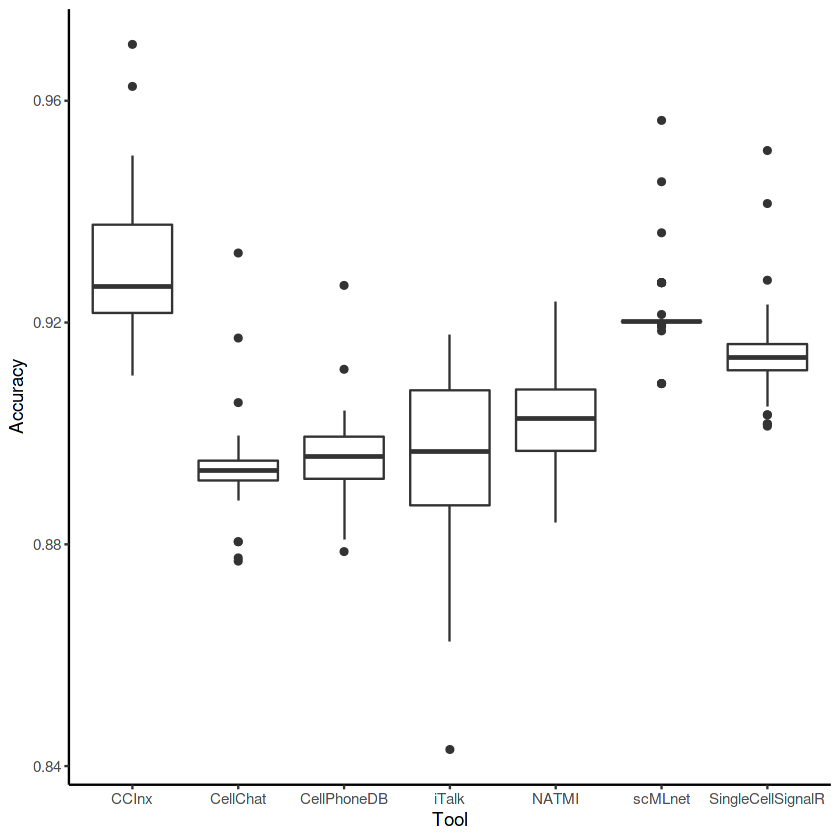

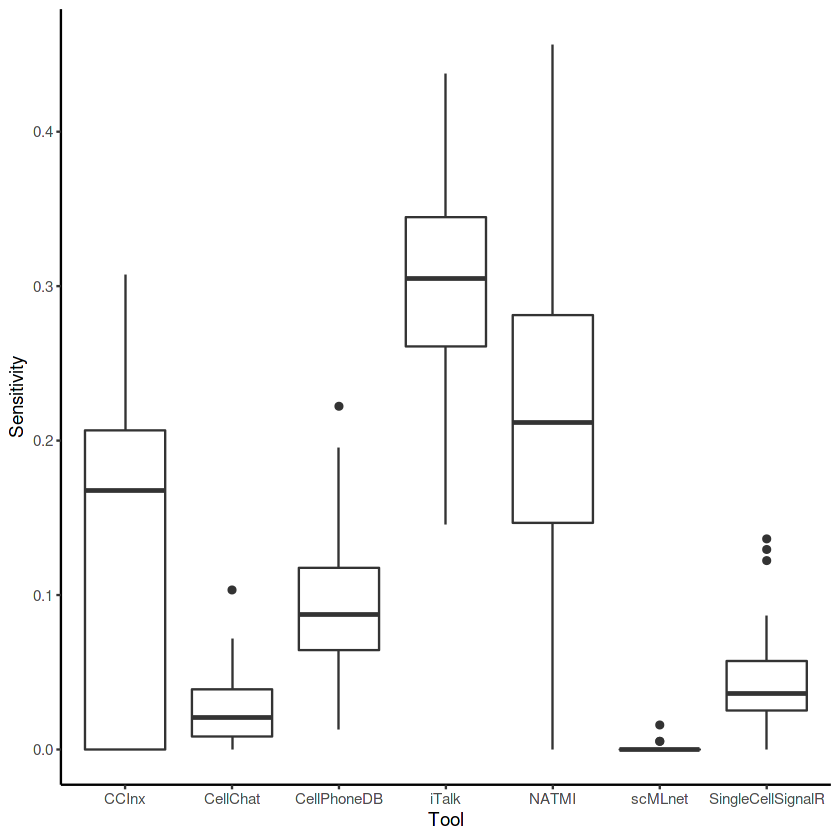

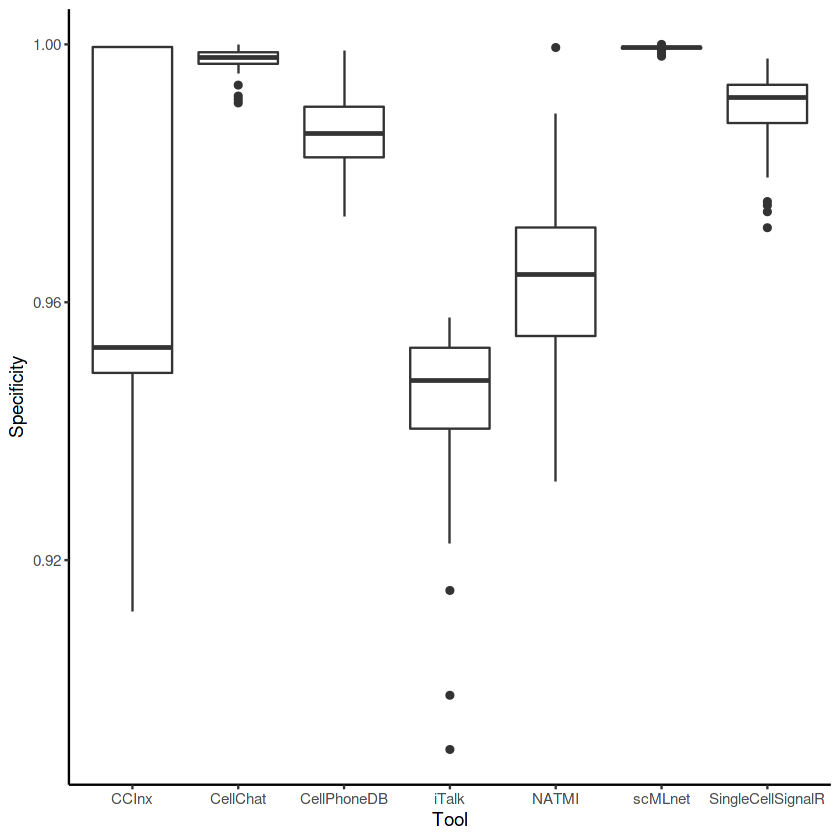

In [28]:
ggplot(data=ssp, aes(x=Tool, y=Accuracy)) + geom_boxplot() + theme_classic()
ggplot(data=ssp, aes(x=Tool, y=Sensitivity)) + geom_boxplot() + theme_classic()
ggplot(data=ssp, aes(x=Tool, y=Specificity)) + geom_boxplot() + theme_classic()

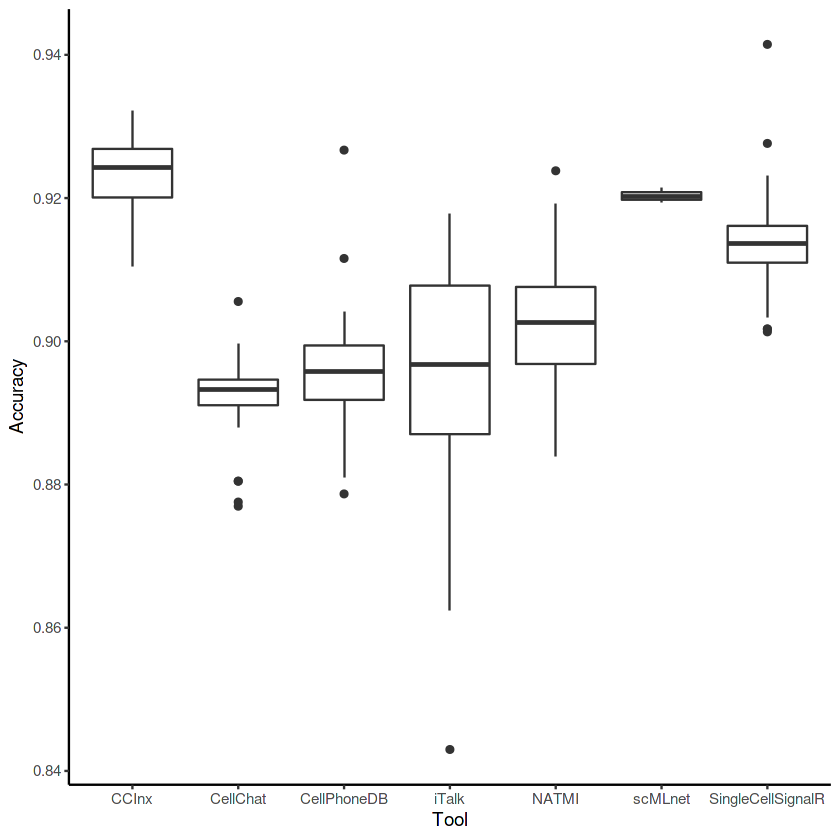

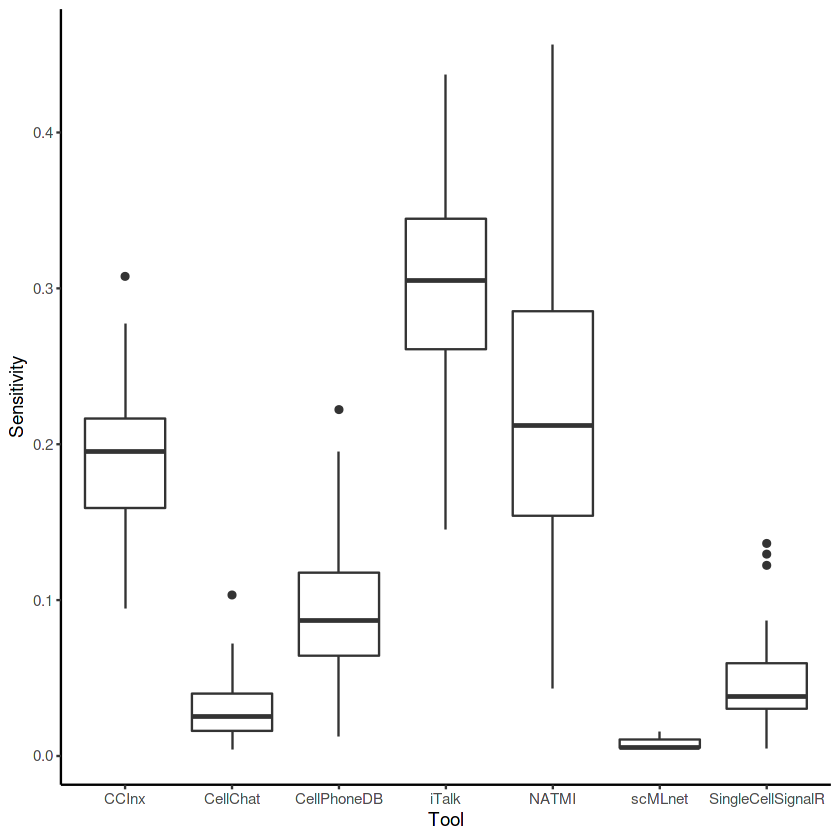

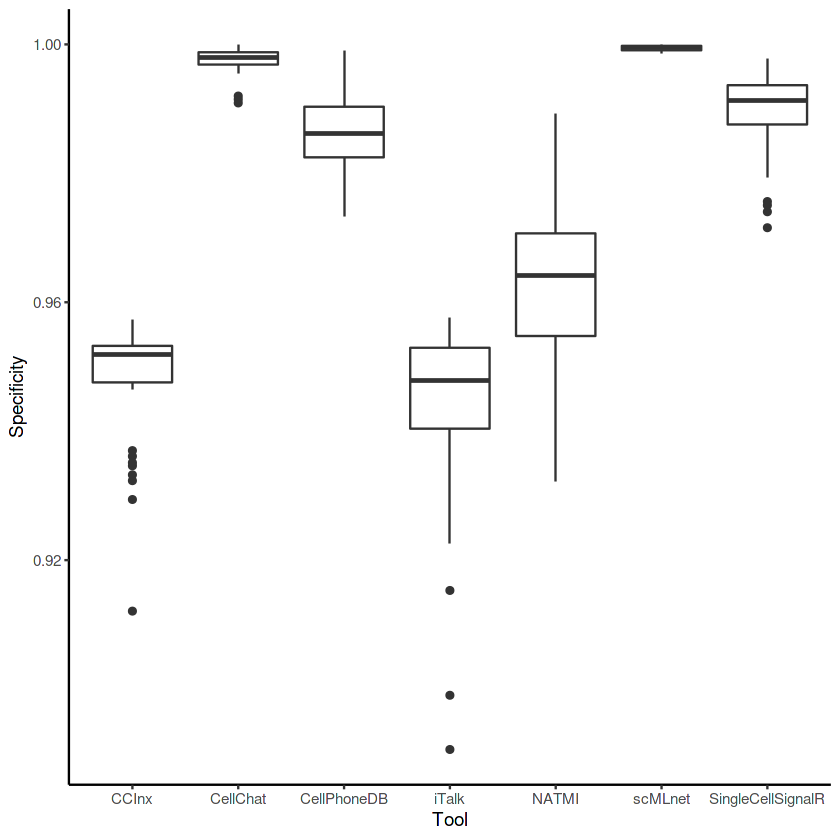

In [29]:
ssp <- ssp[!(ssp$Sensitivity == 0),] # remove 0 L-R pair predicted results
ggplot(data=ssp, aes(x=Tool, y=Accuracy)) + geom_boxplot() + theme_classic()
ggplot(data=ssp, aes(x=Tool, y=Sensitivity)) + geom_boxplot() + theme_classic()
ggplot(data=ssp, aes(x=Tool, y=Specificity)) + geom_boxplot() + theme_classic()

In [30]:
# ROC
rocR <- read.table("Result/rocR.txt", header = T, sep = "\t")
rocP <- read.table("Result/rocP.txt", header = T, sep = "\t")

In [31]:
roc <- as.data.frame(rbind(rocR,rocP))

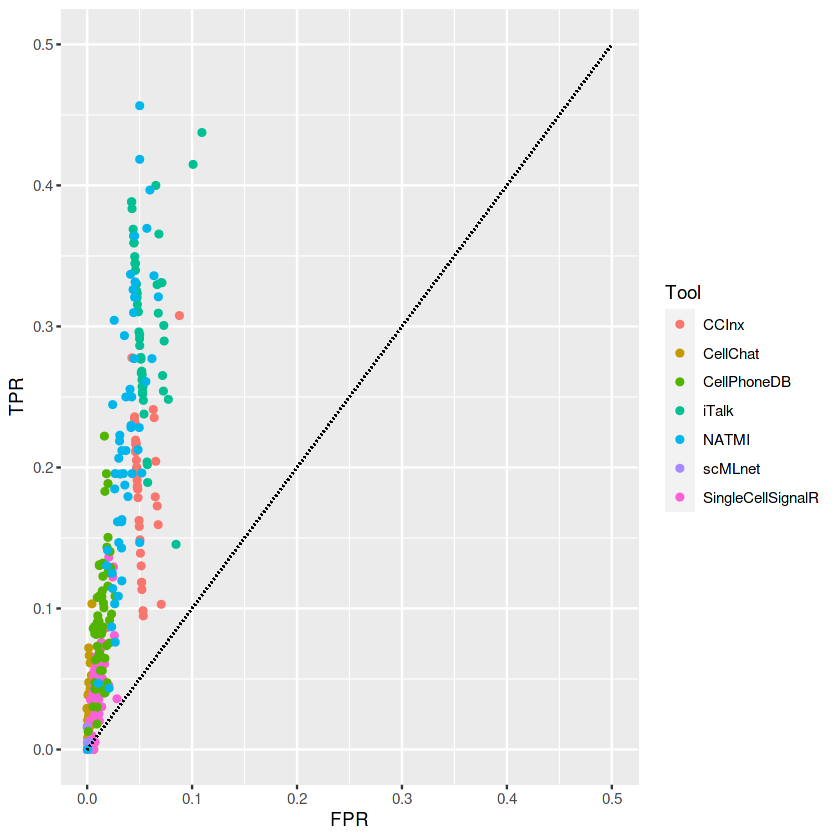

In [32]:
ggplot(data = roc,aes(x=FPR, y=TPR)) + geom_point(aes(color=Tool)) + geom_segment(aes(x=0,y=0,xend=0.5,yend=0.5),linetype="dotted")

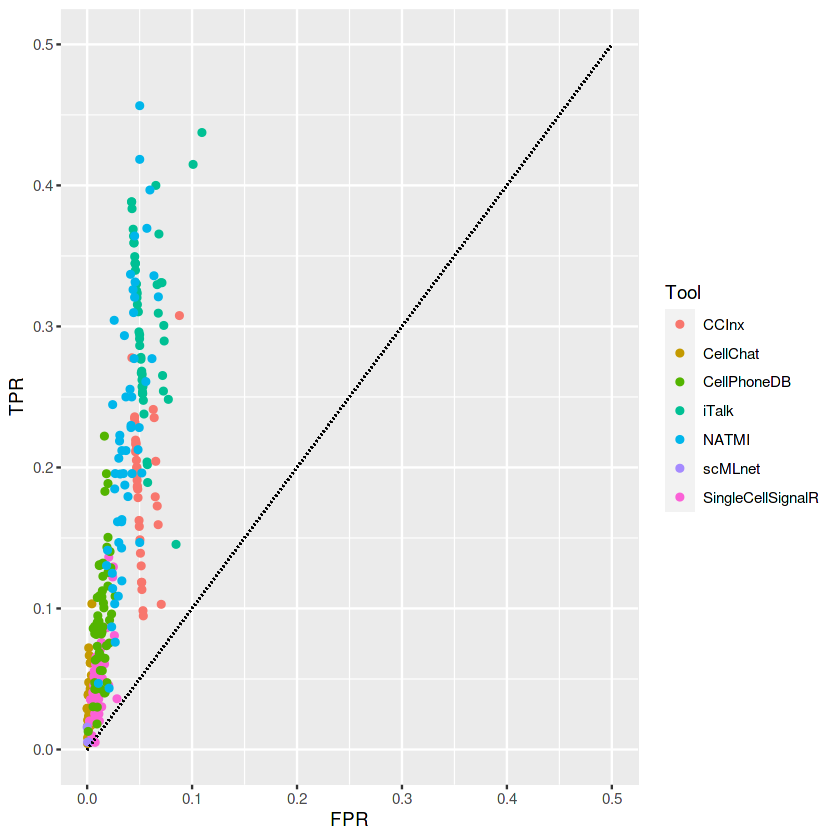

In [33]:
roc <- roc[!(roc$TPR == 0),] # remove 0 L-R pair predicted results
ggplot(data = roc,aes(x=FPR, y=TPR)) + geom_point(aes(color=Tool)) + geom_segment(aes(x=0,y=0,xend=0.5,yend=0.5),linetype="dotted")

In [34]:
ggsave("Result/ROC.pdf")

Saving 6.67 x 6.67 in image



Last modified: 2022.9.21